In [42]:
import networkx as nx
import json
import numpy as np
from time import time
import os
from numpy import save
import sys
import ast
import collections
import matplotlib.pyplot as plt
import pandas as pd
import random
from fuzzywuzzy import fuzz
import seaborn as sns
from sklearn.metrics import roc_curve
import sklearn
from rgraph import Graph, make_graph
import rgraph
import scipy.sparse as sparse
import xml.etree.ElementTree as et
import rgraph
import scipy.sparse as sparse
from collections import defaultdict
import ternary
import matplotlib
import matplotlib.lines as mlines
import csv

%load_ext line_profiler


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [1]:
filepath1 = '../../ontologyAlignment/data.Global/graphs/memory_alpha.nt'
filepath2 = '../../ontologyAlignment/data.Global/graphs/memory_beta.nt'

mapping_file_dir = '../../ontologyAlignment/data.Global/mappings/memory_alpha_vs_beta.xml'
mapping_file_name = mapping_file_dir.split('/')[-1].split('.')[0]



In [2]:
filepath1 = '../data/yago_test.nt'
filepath2 = '../data/dbp_test.nt'

In [2]:
'''
The function "convert_triples_to_list_of_edges" takes the filepath of the input graph as input, 
and returns:
    (i) List of Vertices (id: label)
    (ii) List of Predicates/Relations (id: label)
    (iii) Edge list ((vertex1, vertex2), relation)
'''
def convert_triples_to_list_of_edges(filepath):

    filename = filepath.split('/')[-1].split('.')[0]
    file = open(filepath)

    vertex_dict = {}
    pred_dict = {}

    vc, pc = 0, 0
    edges = []
    adjacency_list = {}
    
    for line in file:
        line_split = line.split(' ')
        sub = line_split[0]
        pred = line_split[1]
        obj = line_split[2]
        if sub not in vertex_dict:
            vertex_dict[sub] = vc
            vc+=1
        if obj not in vertex_dict:
            vertex_dict[obj] = vc
            vc+=1
        if pred not in pred_dict:
            pred_dict[pred] = pc
            pc+=1

        edges.append([vertex_dict.get(sub), vertex_dict.get(obj), pred_dict.get(pred)])

    print('\nGraph: ', filename)
    print('Number of vertices: ', vc)
    print('Number of edges: ', len(edges))
    print('Number of relations(edge labels): ', pc)
    print('\n')

    return vertex_dict, pred_dict, edges


def adj_shape(v1, p1):
    return (len(v1), len(v1), len(p1))


In [3]:
'''
n: nodes dict
p: predicates dict 
e: edge list
al: adj list
am: adj matrix
im: incidence matrix
1,2: Graph1, graph2
'''

v1, p1, e1 = convert_triples_to_list_of_edges(filepath1)
v2, p2, e2 = convert_triples_to_list_of_edges(filepath2)



Graph:  memory_alpha
Number of vertices:  323301
Number of edges:  2526928
Number of relations(edge labels):  342



Graph:  memory_beta
Number of vertices:  315359
Number of edges:  2542909
Number of relations(edge labels):  440




In [7]:
def get_incidence_matrix(v, p, e):
    ts = time()
    shape = adj_shape(v, p)
    adj = np.array(e)
    d, vals = rgraph.clean_adjacency(adj, values=None)
    print('==> Incidence matrix generation started')
    im = sparse.lil_matrix((len(v), len(p)), dtype=np.float32)
    for i in range(len(d)):
        im[d[i][0],d[i][2]]+=1
        
    print('==> Returning incidence matrix')
    print('==> Time taken: {:.4f} secs.\n'.format(time()-ts))
    return im

In [8]:
im1 = get_incidence_matrix(v1, p1, e1)
im2 = get_incidence_matrix(v2, p2, e2)

Cleaning adjacency..
==> Adjacency made symmetric: 0.1288 secs.
==> Unique rows extraction & re-ordering: 2.6636 secs.
==> Adjacency cleaned: 2.9180 secs.
==> Incidence matrix generation started
==> Returning incidence matrix
==> Time taken: 47.2737 secs.

Cleaning adjacency..
==> Adjacency made symmetric: 0.1270 secs.
==> Unique rows extraction & re-ordering: 2.4779 secs.
==> Adjacency cleaned: 2.7326 secs.
==> Incidence matrix generation started
==> Returning incidence matrix
==> Time taken: 49.2290 secs.



In [9]:
im1

<323301x342 sparse matrix of type '<class 'numpy.float32'>'
	with 1255921 stored elements in List of Lists format>

In [10]:

def load_node_equivalences(v1, v2, mapping_file_dir):
    mapping = et.parse(mapping_file_dir)
    root = mapping.getroot()
    v1_e = []
    v2_e = []
    for child in root:
        for grand in child.iter('{http://knowledgeweb.semanticweb.org/heterogeneity/alignment}map'):
            node1 = '<'+str(grand[0][0].attrib.values())[14:-3]+'>'
            node2 = '<'+str(grand[0][1].attrib.values())[14:-3]+'>'
            if v1.get(node1) and v2.get(node2):
                v1_e.append(v1.get(node1))
                v2_e.append(v2.get(node2)) 
            
    return v1_e, v2_e

def load_relation_equivalences(mapping_file_dir):
    mapping = et.parse(mapping_file_dir)
    root = mapping.getroot()
    pred_equivalence_dict = {}
    for child in root:
        for grand in child.iter('{http://knowledgeweb.semanticweb.org/heterogeneity/alignment}map'):
            node1 = '<'+str(grand[0][0].attrib.values())[14:-3]+'>'
            node2 = '<'+str(grand[0][1].attrib.values())[14:-3]+'>'
            if '/property/' in node1 and node2:
                pred_equivalence_dict[node1] = node2
            
    return pred_equivalence_dict


'''Getting the list of equivalent nodes, sorted by index'''
v1_e, v2_e = load_node_equivalences(v1, v2, mapping_file_dir)
pred_equivalence_dict = load_relation_equivalences(mapping_file_dir)


In [102]:

# def load_node_equivalences(v1, v2):
    
#     ts = time()
#     print("Started computing node equivalences")
#     v1_list = list(v1.keys())
#     v2_list = list(v2.keys())
    
#     i=0
#     remove_flag=0
    
#     v1_e = []
#     v2_e = []

#     while(i<len(v1_list)):
#         j=0
#         val1 = v1_list[i]
#         while(j<len(v2_list)):
#             val2 = v2_list[j]
#             score = fuzz.token_set_ratio(val1, val2)
#             if score>95:
#                 v1_e.append(v1.get(val1))
#                 v2_e.append(v2.get(val2))                
#                 v1_list.remove(val1)
#                 v2_list.remove(val2)
#                 remove_flag=1
#                 break
#             j+=1
#         if remove_flag:
#             remove_flag=0
#             continue
#         i+=1
    
#     if len(v1_e)==len(v2_e):
#         print('Total equivalent vertices found: ', len(v1_e))

#     print('Time taken: {:.4f} secs.\n'.format(time()-ts))

#     return v1_e, v2_e

# v1_e, v2_e = load_node_equivalences(v1, v2)
# pred_equivalence_dict = {
#         '<isCitizenOf>':'dbo:nationality',
#         '<isMarriedTo>':'dbo:spouse',
#         '<wasBornIn>':'dbo:birthPlace',
#         '<graduatedFrom>':'dbo:almaMater',
#         '<livesIn>':'dbo:residence',
#         '<hasWonPrize>':'dbo:award',
#         '<diedIn>':'dbo:deathPlace'
#     }


In [11]:
'''Extracting the sub-incidence matrix (taking equivalent vertices as index)'''

im1_e = im1[v1_e].toarray()
im2_e = im2[v2_e].toarray()
degree_product_org = np.zeros((len(p1), len(p2)))

degree_1 = []
degree_2 = []

for i in range(len(v1_e)):
    degree_1.append(sum(im1_e[i]))
    degree_2.append(sum(im2_e[i]))

degree_1 = np.array(degree_1).reshape(len(degree_1),1)
degree_2 = np.array(degree_2).reshape(len(degree_2),1)

im1_e = im1_e/degree_1
im2_e = im2_e/degree_2

degree_product_org = np.matmul(im1_e.transpose(), im2_e)
degree_product_org_df = pd.DataFrame(degree_product_org, index=list(p1), columns=list(p2))
degree_product_org_df


,<http://dbkwik.webdatacommons.org/ontology/wikiPageWikiLink>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://xmlns.com/foaf/0.1/depiction>,<http://xmlns.com/foaf/0.1/thumbnail>,<http://dbkwik.webdatacommons.org/ontology/wikiPageWikiLinkText>,<http://purl.org/dc/terms/subject>,<http://purl.org/dc/elements/1.1/rights>,<http://www.w3.org/2000/01/rdf-schema#comment>,<http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/type>,<http://www.w3.org/2004/02/skos/core#altLabel>,...,<http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/relative(s)_>,<http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/tye>,<http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/prevdc>,<http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/birthdate>,<http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/formt>,<http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/climate>,<http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/formet>,<http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/ross>,<http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/nextdc>,<http://dbkwik.webdatacommons.org/memory-beta.wikia.com/property/armament>
<http://xmlns.com/foaf/0.1/thumbnail>,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
<http://xmlns.com/foaf/0.1/depiction>,203.184094,6.066903,10.072765,0.0,9.431561,12.210746,0.0,5.967095,1.278621,7.026643,...,0.0,0.000001,0.000272,0.0,0.000092,0.0,0.000176,0.000512,0.000371,0.0
<http://www.w3.org/2000/01/rdf-schema#label>,127.537233,18.523408,6.414835,0.0,6.581047,9.042719,0.0,4.556621,0.765562,5.205641,...,0.0,0.000001,0.000104,0.0,0.000046,0.0,0.000088,0.000512,0.000104,0.0
<http://dbkwik.webdatacommons.org/ontology/wikiPageWikiLink>,4557.766150,108.403148,180.247808,0.0,178.176941,241.718753,0.0,105.985164,26.640248,127.791760,...,0.0,0.000295,0.008417,0.0,0.002910,0.0,0.004303,0.009734,0.007257,0.0
<http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/gender>,12.261135,0.376352,0.547057,0.0,0.505953,1.363703,0.0,0.354633,0.113214,0.421090,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
<http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/imageorbitalcap>,0.021598,0.000689,0.000689,0.0,0.000689,0.001627,0.0,0.000689,0.000000,0.000689,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
<http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/gemder>,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
<http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/narc3partcount>,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
<http://dbkwik.webdatacommons.org/memory-alpha.wikia.com/property/anextinoversetimeline>,0.003051,0.000019,0.000019,0.0,0.000019,0.000038,0.0,0.000019,0.000019,0.000019,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0


In [45]:
degree_product_org_df.to_pickle('rel_sim.pkl')

In [47]:
a = pd.read_pickle('rel_sim.pkl')

In [10]:

# plt.figure(figsize=(10,10))
# sns.set(font_scale=1.2)
# sns.heatmap(degree_product_org_df, annot=True, annot_kws={"size": 8}, \
#            cmap=sns.diverging_palette(0, 200, n=500),\
#            yticklabels=list(p1.keys()), xticklabels=list(p2.keys()))

#### Configuration model

In [104]:
def get_replica_sub_swap(im, edgelist):
    
    ts = time()

    replica = sparse.lil_matrix(im.shape, dtype=np.float32)
    replica = replica.toarray()

    len_e = len(edgelist)
    len_e = len_e if len_e%2==0 else len_e-1
    indices_e = [i for i in range(len_e)]
    random.shuffle(indices_e)

    m = (len(indices_e)+1)//2

    for i in range(m):
        v1, o1, p1 = edgelist[indices_e[i]]
        v2, o2, p2 = edgelist[indices_e[i+m]]

        replica[v2][p1]+=1
        replica[o1][p1]+=1
        replica[v1][p2]+=1
        replica[o2][p2]+=1
            
#     print('==> Replica creation: {:.4f} secs.\n'.format(time()-ts))

    return replica

def get_replica_obj_swap(im, edgelist):
    
    ts = time()

    replica = sparse.lil_matrix(im.shape, dtype=np.float32)
    replica = replica.toarray()

    len_e = len(edgelist)
    len_e = len_e if len_e%2==0 else len_e-1
    indices_e = [i for i in range(len_e)]
    random.shuffle(indices_e)

    m = (len(indices_e)+1)//2

    for i in range(m):
        v1, o1, p1 = edgelist[indices_e[i]]
        v2, o2, p2 = edgelist[indices_e[i+m]]

        replica[v1][p1]+=1
        replica[o2][p1]+=1
        replica[v2][p2]+=1
        replica[o1][p2]+=1
            
#     print('==> Replica creation: {:.4f} secs.\n'.format(time()-ts))

    return replica

def get_replica_pred_swap(im, edgelist):
    
    ts = time()

    replica = sparse.lil_matrix(im.shape, dtype=np.float32)
    replica = replica.toarray()

    len_e = len(edgelist)
    len_e = len_e if len_e%2==0 else len_e-1
    indices_e = [i for i in range(len_e)]
    random.shuffle(indices_e)

    m = (len(indices_e)+1)//2

    for i in range(m):
        v1, o1, p1 = edgelist[indices_e[i]]
        v2, o2, p2 = edgelist[indices_e[i+m]]

        replica[v1][p2]+=1
        replica[o1][p2]+=1
        replica[v2][p1]+=1
        replica[o2][p1]+=1
            
#     print('==> Replica creation: {:.4f} secs.\n'.format(time()-ts))

    return replica

def get_replica_mix_swap(im, edgelist):
    
    ts = time()

    replica = sparse.lil_matrix(im.shape, dtype=np.float32)
    replica = replica.toarray()

    len_e = len(edgelist)
    len_e = len_e if len_e%2==0 else len_e-1
    indices_e = [i for i in range(len_e)]
    random.shuffle(indices_e)

    m = (len(indices_e)+1)//2

    for i in range(m):
        v1, o1, p1 = edgelist[indices_e[i]]
        v2, o2, p2 = edgelist[indices_e[i+m]]

        flag = random.randint(0,2)

        if flag==1:
            replica[v1][p1]+=1
            replica[o2][p1]+=1
            replica[v2][p2]+=1
            replica[o1][p2]+=1
        elif flag==2:
            replica[v1][p2]+=1
            replica[o1][p2]+=1
            replica[v2][p1]+=1
            replica[o2][p1]+=1
        else:
            replica[v2][p1]+=1
            replica[o1][p1]+=1
            replica[v1][p2]+=1
            replica[o2][p2]+=1
            
#     print('==> Replica creation: {:.4f} secs.\n'.format(time()-ts))

    return replica

In [105]:
def get_replica_mix_swap_with_probability(im, edgelist, probs):
    
    ts = time()
    replica = sparse.lil_matrix(im.shape, dtype=np.float32)
    replica = replica.toarray()

    len_e = len(edgelist)
    len_e = len_e if len_e%2==0 else len_e-1
    indices_e = [i for i in range(len_e)]
    random.shuffle(indices_e)

    m = (len(indices_e)+1)//2

    for i in range(m):
        v1, o1, p1 = edgelist[indices_e[i]]
        v2, o2, p2 = edgelist[indices_e[i+m]]

        flag = np.random.choice([1,2,3], p=probs)
        if flag==1: #Obj_swap
            replica[v1][p1]+=1
            replica[o2][p1]+=1
            replica[v2][p2]+=1
            replica[o1][p2]+=1
        elif flag==2: #Pred_swap
            replica[v1][p2]+=1
            replica[o1][p2]+=1
            replica[v2][p1]+=1
            replica[o2][p1]+=1
        else: #Sub_swap
            replica[v2][p1]+=1
            replica[o1][p1]+=1
            replica[v1][p2]+=1
            replica[o2][p2]+=1
                        
    return replica

In [106]:
def get_replicas_by_methods(im1, im2, v1_e, v2_e, n, p):
    
    replica_method='get_replica_mix_swap_with_probability'
    f=globals()[replica_method]
    degree_products = []

    for _ in range(n):
        replica1 = f(im1, e1, p)
        replica2 = f(im2, e2, p)

        replica1_e = replica1[v1_e]
        replica2_e = replica2[v2_e]
                 
        replica1_e = replica1_e/degree_1
        replica2_e = replica2_e/degree_2

        degree_product = np.matmul(replica1_e.transpose(), replica2_e)

        degree_products.append(degree_product)

    degree_products = np.array(degree_products)
    
    return degree_products

In [107]:
def get_auc_from_degree_products(degree_products):
    degree_product_avg = np.zeros((len(p1), len(p2)))
    degree_product_std = np.zeros((len(p1), len(p2)))

    for i in range(len(p1)):
        for j in range(len(p2)):
            degree_product_avg[i][j] = np.average(degree_products[:,i,j])
            degree_product_std[i][j] = np.std(degree_products[:,i,j])

    degree_product_zscore = np.zeros((len(p1), len(p2)))

    for i in range(len(degree_product_org)):
        for j in range(len(degree_product_org[0])):
            if degree_product_std[i,j]:
                degree_product_zscore[i,j] = (degree_product_org[i,j] - degree_product_avg[i,j])/degree_product_std[i,j]
            else:
                degree_product_zscore[i,j] = 0

    degree_product_zscore_df = pd.DataFrame(degree_product_zscore, index=list(p1), columns=list(p2))

    zscore_list = []
    for i in list(p1.keys()):
        for j in list(p2.keys()):
            zscore_list.append([i,j, degree_product_zscore_df.loc[i,j]])

    zscore_list = np.array(zscore_list)

    zscore_list = zscore_list[zscore_list[:, 2].argsort()][::-1]

    pred_equivalence = []
    for i in range(len(zscore_list)):
        if pred_equivalence_dict.get(zscore_list[i,0]) == zscore_list[i,1]:
            pred_equivalence.append(1)
        else:
            pred_equivalence.append(0)

    pred_y = np.array(zscore_list[:,2]).astype(float)
    y = np.array(pred_equivalence)
    fpr, tpr, threshold = roc_curve(y, pred_y)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    return roc_auc

In [ ]:
replica_count=10
aucs={}
probs=[p/10 for p in range(0, 11)]
for i in range(len(probs)+1):
    for j in range(len(probs)-i):
        k=len(probs)-i-j-1
        curr_prob=[probs[i],probs[j],probs[k]]
        degree_products=get_replicas_by_methods(im1,im2,v1_e,v2_e,replica_count,curr_prob)
        auc=get_auc_from_degree_products(degree_products)
        print(f'o:{curr_prob[0]},p:{curr_prob[1]},s:{curr_prob[-1]}--Auc:{auc}')
        aucs[(curr_prob[0], curr_prob[1], curr_prob[2])]=auc

o:0.0,p:0.0,s:1.0--Auc:0.8382392814468484
o:0.0,p:0.1,s:0.9--Auc:0.8941102796836682


In [110]:
with open(f'./output/aucs_ternary_plots/aucs/{mapping_file_name}_{replica_count}.txt', mode='w') as f:
    f.write(str(aucs))

#### Drawing Ternary Plots

In [111]:
def get_auc_by_probs(x):
    return aucs[(x[0],x[1],x[2])]

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (5, 4)

## Boundary and Gridlines
scale = 10
figure, tax = ternary.figure(scale=scale)

# Draw Boundary and Gridlines
tax.boundary(linewidth=1)
tax.gridlines(color="black", multiple=1, linewidth=.3)
tax.gridlines(color="blue", multiple=.5, linewidth=0.1)

# Set Axis labels and Title
fontsize = 8
offset = 0.18
tax.set_title(mapping_file_name+'_'+str(replica_count)+'\n', fontsize=fontsize)
tax.left_axis_label("Predicate swap", fontsize=fontsize, offset=offset)
tax.right_axis_label("Object swap", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Subject swap", fontsize=fontsize, offset=offset)

# Set ticks
ticks = [i / float(scale) for i in range(scale+1)]
tax.ticks(ticks=ticks,axis='rlb', linewidth=1, multiple=1, offset=0.03, \
          fontsize=fontsize,tick_formats="%.1f", clockwise=True)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.heatmapf(get_auc_by_probs, style='h', cmap='plasma')

ternary.plt.show()



In [113]:
figure.savefig(f'./output/aucs_ternary_plots/ternary_plots/{mapping_file_name}_{replica_count}.png', dpi=300, bbox_inches='tight')


In [93]:
''' Reading dict from text file '''
filepath="./output/aucs_ternary_plots/aucs/memory_alpha_vs_stexpanded_10.txt"
filename=filepath.split('/')[-1].split('.')[0]
file = open(filepath, "r")
contents=file.read()
aucs = ast.literal_eval(contents)
file.close()

replica_count = 10

def get_max_coor():
    maxauc=0.0
    for k,v in aucs.items():
        if v>maxauc:
            maxauc=v
            maxcoor=k
    maxcoor=list(maxcoor)
    maxcoor=[i*10 for i in maxcoor]
    return maxcoor

In [94]:
def plot_ternary():

    def get_auc_by_probs(x):
        return aucs[(x[0],x[1],x[2])]

    matplotlib.rcParams['figure.dpi'] = 200
    matplotlib.rcParams['figure.figsize'] = (5, 4)

    ## Boundary and Gridlines
    scale = 10
    figure, tax = ternary.figure(scale=scale)

    # Draw Boundary and Gridlines
    tax.boundary(linewidth=1)
    tax.gridlines(color="black", multiple=1, linewidth=.3)
    tax.gridlines(color="blue", multiple=.5, linewidth=0.1)

    # Set Axis labels and Title
    fontsize = 8
    offset = 0.18
    tax.set_title(filename+'\n', fontsize=fontsize)
    tax.left_axis_label("Predicate swap", fontsize=fontsize, offset=offset)
    tax.right_axis_label("Object swap", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("Subject swap", fontsize=fontsize, offset=offset)

    # Set ticks
    ticks = [i / float(scale) for i in range(scale+1)]
    tax.ticks(ticks=ticks,axis='rlb', linewidth=1, multiple=1, offset=0.03, \
              fontsize=fontsize,tick_formats="%.1f", clockwise=True)

    # Background color
    tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially

    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')

    p1 = get_max_coor()
    p2 = get_max_coor()
    tax.line(p1, p2, linewidth=.2, marker='*', color='black', linestyle="-.")
    # Load data
    tax.heatmapf(get_auc_by_probs, style='h', cmap='plasma',cbarlabel='AUC')
    
    # Set legend
    max_auc_star = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                          markersize=8, label='Max AUC')
    plt.legend(handles=[max_auc_star])
    
    tax.show()
    figure.savefig(f'./output/aucs_ternary_plots/ternary_plots/{filename}_2.png', dpi=300, bbox_inches='tight')


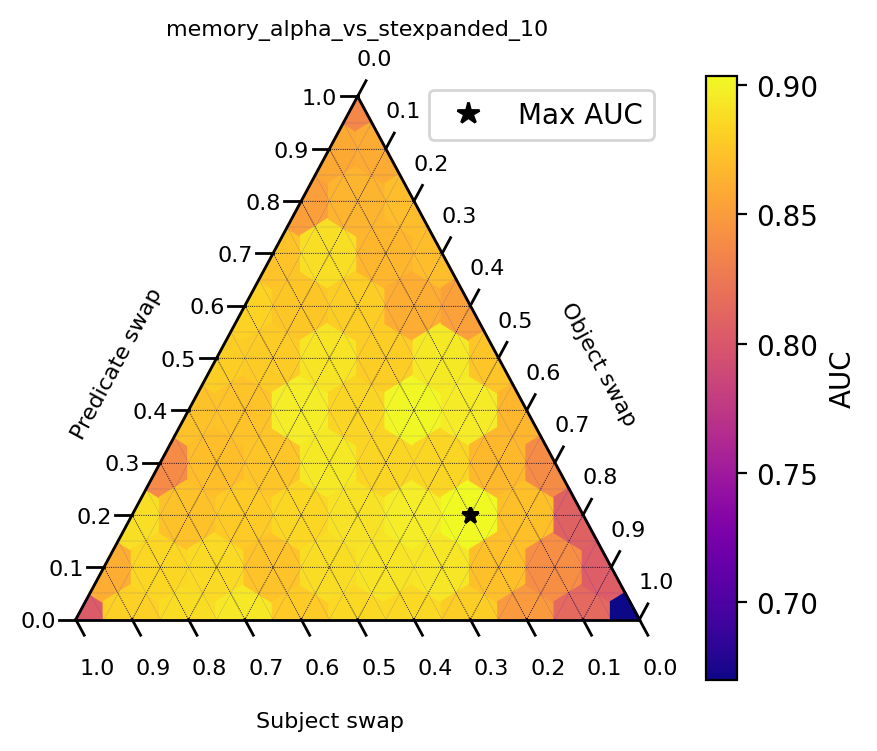

In [95]:
plot_ternary()